# CNN Detection

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from re import findall
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.data import Dataset
from tensorflow.keras import layers, models

2023-10-13 07:56:42.753930: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 07:56:42.876654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 07:56:43.475835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Ubuntu setting
from os import environ
environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'

In [3]:
tf.config.list_physical_devices('GPU')

2023-10-12 10:50:25.912437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-12 10:50:25.952849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-12 10:50:25.953025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## I. Brief Introduction

* Goal:

    The task of the project is to predict if tumors are on small pathology images. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.

* Data description

    1. Data for training and testing is named with an image ID, and we have 220,000 images for training. There are 57,500 images we need to predict if tumors are in the image.

    2. 

## Load

In [6]:
# Set CWD
# Mac 
# cwd = Path.home() /'Library/CloudStorage/OneDrive-GiantGroup/model training/CNN/train'
# Ubuntu
cwd = Path.home() /'Desktop/CNN/CNN/train/'
img_path = [i.as_posix() for i in cwd.glob('*.tif')]

In [3]:
# Training labels
df_labels = pd.read_csv('/home/ivan/Desktop/CNN/CNN/train_labels.csv')
labels_dic = {k : v for k, v in zip(df_labels.id, df_labels.label)}
# Data preview
df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
Path.home()

PosixPath('/Users/ivanliu')

In [3]:
Path.cwd()

PosixPath('/Users/ivanliu/Library/CloudStorage/OneDrive-GiantGroup/model training/code')

In [20]:
# Define a class to load images
class LoadData(Dataset):
    
    def __init__(self, cwd, labels_dic):
        
        # Image dataset folder
        self.cwd = cwd
        # Dataset for Train / Test
        self.datatype = cwd.as_posix().split('/')[0]
        # Get image paths
        self.img_path = [i.as_posix() for i in cwd.glob('*.tif')]
        # Labels dict
        self.labels_dic = labels_dic
        # Transform the image 
        # self.transform = transform

        # Pytorch
        # transform = transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]),


        # Create labels
        if self.datatype =='train':
            self.labels = [labels_dic[i.split('/')[-1].split('.')[0]] for i in self.img_path]
        else:
            self.labels = [0 for _ in range(len(self.img_path))]

    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_path[idx])
        # Tensorflow image preprocessing
        img = tf.image.central_crop(img, .5)
        img = tf.convert_to_tensor()
        img_id = self.img_path.split('/')[-1].split('.')[0]

        if self.datatype == 'train':
            label = self.labels_dic[img_id]
        else:
            label = 0
        
        return img, label


In [35]:
# Image dataset folder

# Get image paths
# Labels dict


# Define a class to load images with Tensorflow Dataset
class LoadData(Dataset):
    
    def _generator(num_samples):

        for idx in range(num_samples):

            img = Image.open(img_path[idx])
            # Tensorflow image preprocessing
            img = tf.image.central_crop(img, .5)
            img = tf.convert_to_tensor()
            img_id = img_path[idx].split('/')[-1].split('.')[0]
            label = labels_dic[img_id]
            
            yield (img, label)
    
    def __new__(cls, num_samples = 220025):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature = tf.TensorSpec(shape=(32, 32), dtype = tf.float16),
            args = (num_samples,)

        )


In [36]:
LoadData()

<_FlatMapDataset element_spec=TensorSpec(shape=(32, 32), dtype=tf.float16, name=None)>

In [37]:

# Load train data
train_data = LoadData()

CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 15.8 ms


In [38]:
type(train_data)

tensorflow.python.data.ops.flat_map_op._FlatMapDataset

### Creating Dataset

In [7]:
image_count = len(img_path)
print(image_count)

220025


In [24]:
tf.data.Dataset.list_files(str(cwd), shuffle=False)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [27]:
tf.data.Dataset.from_tensor_slices(img_path)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [28]:
# list_ds = tf.data.Dataset.list_files(str(cwd), shuffle=False)
list_ds = tf.data.Dataset.from_tensor_slices(img_path)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [29]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/ivan/Desktop/CNN/CNN/train/0cf024e9117fbaa010cf59eeba690de2d656d9b2.tif'
b'/home/ivan/Desktop/CNN/CNN/train/e6a9b0f722e0857611127724fa8ac26fba141ec2.tif'
b'/home/ivan/Desktop/CNN/CNN/train/59ec9d57940a123a851ad61dfd8514f65f4562a4.tif'
b'/home/ivan/Desktop/CNN/CNN/train/2f03961cd5687a4535e107ec33375d876367e8ec.tif'
b'/home/ivan/Desktop/CNN/CNN/train/3d42dc4354d294fa921383cc44b9e2890a8615e5.tif'


In [30]:
str(tf.strings.split(f.numpy(), '/')[-1].numpy(), encoding='utf-8')

'3d42dc4354d294fa921383cc44b9e2890a8615e5.tif'

In [31]:
labels_dic[str(tf.strings.split(f.numpy(), '/')[-1].numpy(), encoding='utf-8')[:-4]]

0

In [20]:
train_ds

<_SkipDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [32]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [33]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

176020
44005


In [35]:
def get_label(file_path):
    print(file_path)
    # Convert the path to a list of path components
    img_id = str(tf.strings.split(file_path.numpy(), '/')[-1].numpy(), encoding='utf-8')[:-4]
    # Use image id to get label
    label = labels_dic[img_id]
    return label

In [36]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tfio.experimental.image.decode_tiff(img)
    # Resize the image to the desired size
    return img

In [37]:
def process_path(file_path):
  print(file_path)
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)


AttributeError: in user code:

    File "/tmp/ipykernel_6368/1221142455.py", line 3, in process_path  *
        label = get_label(file_path)
    File "/tmp/ipykernel_6368/213758223.py", line 4, in get_label  *
        img_id = str(tf.strings.split(file_path.numpy(), '/')[-1].numpy(), encoding='utf-8')[:-4]

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [44]:
train = train_data.shuffle(1000).batch(32)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [45]:
model.fit(train, epochs=2)

Epoch 1/2


ValueError: in user code:

    File "/home/ivan/mambaforge-pypy3/envs/ml/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/ivan/mambaforge-pypy3/envs/ml/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ivan/mambaforge-pypy3/envs/ml/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/ivan/mambaforge-pypy3/envs/ml/lib/python3.9/site-packages/keras/src/engine/training.py", line 1082, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/ivan/mambaforge-pypy3/envs/ml/lib/python3.9/site-packages/keras/src/engine/training.py", line 1036, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=<keras.src.losses.BinaryCrossentropy object at 0x7f29ccb560d0>, and therefore expects target data to be provided in `fit()`.


In [3]:
# Training images
train_images = Path.home() /'Library/CloudStorage/OneDrive-GiantGroup/model training/CNN/train'
train_image_path = [i.as_posix() for i in train_images.glob('*.tif')]
train_image_id = [findall(r'[^\/]+(?=\.)', i)[0] for i in train_image_path]

# Test images
test_images = Path.home() /'Library/CloudStorage/OneDrive-GiantGroup/model training/CNN/test' 
test_image_path = [i.as_posix() for i in test_images.glob('*.tif')]
# Dataset info
print(f"Number of images for training: {len(train_image_path)}")
print(f"Number of images for testing: {len(test_image_path)}")

Number of images for training: 220025
Number of images for testing: 57458


In [4]:
# Training images
train_images = Path.home() /'Desktop/CNN/CNN/train/'
train_image_path = [i.as_posix() for i in train_images.glob('*.tif')]
train_image_id = [findall(r'[^\/]+(?=\.)', i)[0] for i in train_image_path]
df_labels = pd.read_csv('/home/ivan/Desktop/CNN/CNN/train_labels.csv')

# Test images
test_images = Path.home() /'Desktop/CNN/CNN/test/'
test_image_path = [i.as_posix() for i in test_images.glob('*.tif')]
# Dataset info
print(f"Number of images for training: {len(train_image_path)}")
print(f"Number of images for testing: {len(test_image_path)}")

Number of images for training: 220025
Number of images for testing: 57458


In [7]:
# Faster way to load images than matplotlib
train_image_data = np.array([np.array(Image.open(i), dtype='uint8') for i in train_image_path]).reshape(-1, 96, 96, 3)
train_image_data.shape

(220025, 96, 96, 3)

In [4]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [6]:
# Faster way to load images than matplotlib
train_image_data = [load_img(i) for i in train_image_path]
print(f"Image size: {train_image_data[0].size}")
# Show the image
train_image_data[0].show()

Image size: (96, 96)


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/ivan/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/usr/bin/eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


In [ ]:
train_images = img_to_array(train_image_data)
print(train_images[0])
print(f"Image data type: {train_images[0].dtype}")
print(f"Image data shape: {train_images[0].shape}")
print(f"All training image data shape: {train_images.shape}")

In [ ]:
train_images = np.array([img_to_array(i) for i in train_image_data]).reshape(-1, 96, 96, 3)
print(train_images[0])
print(f"Image data type: {train_images[0].dtype}")
print(f"Image data shape: {train_images[0].shape}")
print(f"All training image data shape: {train_images.shape}")

In [13]:
train_images.as_posix()

'/home/ivan/Desktop/CNN/CNN/train'

In [ ]:
test_image_data = np.array([np.array(Image.open(i), dtype='uint8') for i in test_image_path]).reshape(-1, 96, 96, 3)
test_image_data.shape

In [4]:
# Show the training data information
img = plt.imread(train_image_path[0])
print(f"Image data type: {type(img)}")
print(f"Image data shape: {img.shape}")

Image data type: <class 'numpy.ndarray'>
Image data shape: (96, 96, 3)


In [7]:
# df = pd.DataFrame({'path' : train_image_path})
# df['id'] = df['path'].apply(lambda x: findall(r'[^\/]+(?=\.)', x)[0])

# Create a dataframe to store the training data and metadata
df = pd.DataFrame({'id' : train_image_id,})
# Training labels
df_labels = pd.read_csv('/home/ivan/Desktop/CNN/CNN/train_labels.csv')
# df_labels = pd.read_csv('/Users/ivanliu/Library/CloudStorage/OneDrive-GiantGroup/model training/CNN/train_labels.csv')
# Merge training data and labels
df_train = df.merge(df_labels, on = 'id')
# Data preview
df_train.head()

,id,label
0,d690c4e218b177a59cfe1b50b5f0a53bf22e3c94,1
1,04782f4fb3a08572ebc1ba378e6f7d0a74a83e43,0
2,b3175a20603a942482ff62af9e186ac8b42b3df1,0
3,356e0f57f7d8dc56aa8480d95dc4485f2c412391,1
4,7b6f37186925c4ce1720680bbcdfcb0197cf89a9,1


In [6]:
# Data info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    220025 non-null  object
 1   id      220025 non-null  object
 2   data    220025 non-null  object
 3   label   220025 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 6.7+ MB


In [7]:
# Create a dataframe to store the testing data and metadata
df_test = pd.DataFrame({'path' : test_image_path})
df_test['id'] = df_test['path'].apply(lambda x: findall(r'[^\/]+(?=\.)', x)[0])
df_test['data'] = df_test['path'].apply(lambda x: plt.imread(x)/255.0)
# Data preview
df_test.head()

In [9]:
# Save the train/test dataset for future use
path = '/home/ivan/Desktop/CNN/code/'
df_train[['id', 'data', 'label']].to_csv(path + 'train_data.csv', index=False)
df_test[['id', 'data']].to_csv(path + 'test_data.csv', index=False)

In [10]:
# Load ()failed
# df_train = pd.read_csv(path + 'train_data.csv')
# df_test = pd.read_csv(path + 'test_data.csv')

In [12]:
df_train.head()

,id,data,label
0,d690c4e218b177a59cfe1b50b5f0a53bf22e3c94,[[[246 248 247]\n [252 254 253]\n [247 253 2...,1
1,04782f4fb3a08572ebc1ba378e6f7d0a74a83e43,[[[242 241 239]\n [242 241 239]\n [242 241 2...,0
2,b3175a20603a942482ff62af9e186ac8b42b3df1,[[[255 254 245]\n [235 233 238]\n [245 243 2...,0
3,356e0f57f7d8dc56aa8480d95dc4485f2c412391,[[[201 178 196]\n [220 200 212]\n [243 226 2...,1
4,7b6f37186925c4ce1720680bbcdfcb0197cf89a9,[[[101 52 99]\n [ 32 0 23]\n [255 241 2...,1


In [ ]:
# Convert the training images as tensor and apply normalization
img_array_train = df_train['data'].apply(lambda x: (x/255.0).reshape(-1, 96, 96, 3)).values
img_array_test = df_test['data'].apply(lambda x: (x/255.0).reshape(-1, 96, 96, 3)).values
# Concatenate all images
train_images = np.concatenate(img_array_train)
train_labels = df_train['label'].values
test_images = np.concatenate(img_array_test)
# Data info
print(f"Training data shape: {train_images.shape}")
print(f"Test data shape: {test_images.shape}")

## EDA

In [12]:
# Images with / without tumors
df_train['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

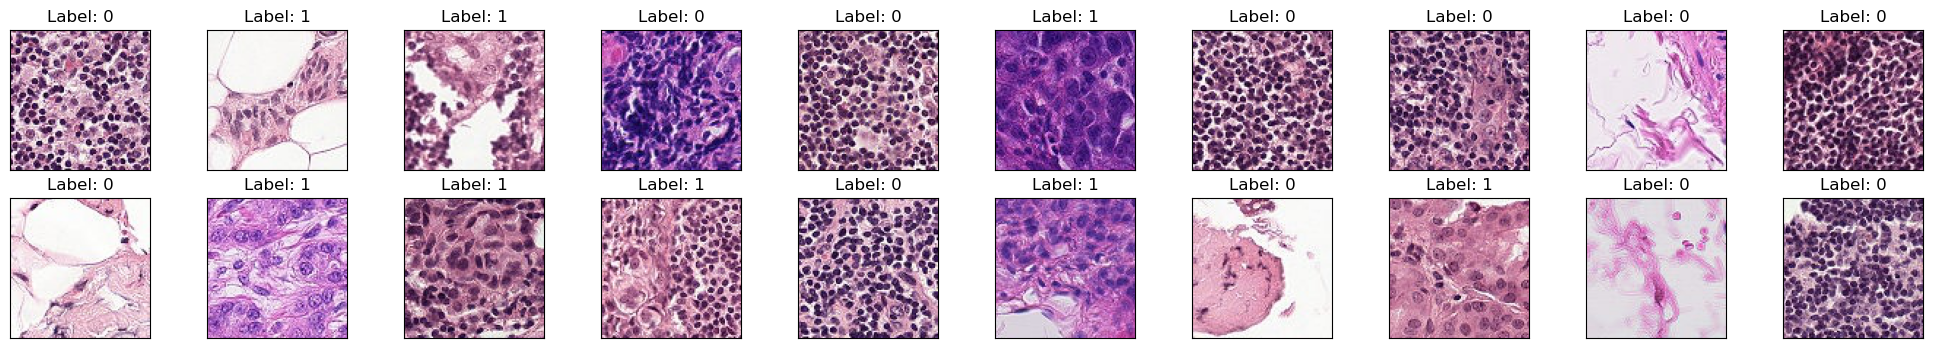

In [11]:
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx, img in enumerate(np.random.choice(train_image_path, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(img)
    plt.imshow(im)
    lab = df_train.loc[df_train['id'] == img.split('/')[-1].split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

## Modeling

### Split

In [ ]:
# Split 20% of training data for validation
train_labels = df_train['label'].values
X_train, X_val, y_train, y_val = train_test_split(train_image_data, train_labels, shuffle=True, test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y val shape: {y_val.shape}")

X_train shape: (176020, 96, 96, 3)
y_train shape: (176020,)
X_val shape: (44005, 96, 96, 3)
y val shape: (44005,)


In [ ]:
# Normalize pixel values to be between 0 and 1
X_train = np.true_divide(X_train, 255, dtype=np.float32)
X_val = np.true_divide(X_val, 255, dtype=np.float32)

In [ ]:
# NOTE !!! Don't run this, the kernel will crash
# Normalize pixel values to be between 0 and 1
# X_train, X_val, y_train, y_val = X_train / 255.0, X_val / 255.0, y_train / 255.0, y_val / 255.0

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 25600)             0

2023-09-28 09:12:48.171179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 09:12:48.218928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 09:12:48.219062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X_train, y_train, 32)
test_gen = DataGenerator(X_val, y_val, 32)

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_gen, epochs=20, 
                    batch_size = 32,
                    validation_data=test_gen,
                    validation_batch_size=32,)

Epoch 1/20


2023-09-28 09:13:03.740513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-09-28 09:13:04.382929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-28 09:13:04.604959: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd0284e3c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-28 09:13:04.604976: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2023-09-28 09:13:04.620187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-28 09:13:04.730070: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lif

5501/5501 [==============================] - 47s 8ms/step - loss: 9.0360 - accuracy: 0.4060 - val_loss: 7.6599 - val_accuracy: 0.4013
Epoch 2/20
5501/5501 [==============================] - 44s 8ms/step - loss: 7.6602 - accuracy: 0.4060 - val_loss: 7.6599 - val_accuracy: 0.4013
Epoch 3/20
5501/5501 [==============================] - 41s 8ms/step - loss: 7.6602 - accuracy: 0.4060 - val_loss: 7.6599 - val_accuracy: 0.4013
Epoch 4/20
5501/5501 [==============================] - 43s 8ms/step - loss: 7.6602 - accuracy: 0.4060 - val_loss: 7.6599 - val_accuracy: 0.4013
Epoch 5/20
5501/5501 [==============================] - 43s 8ms/step - loss: 7.6603 - accuracy: 0.4060 - val_loss: 7.6599 - val_accuracy: 0.4013
Epoch 6/20
5501/5501 [==============================] - 44s 8ms/step - loss: 7.6602 - accuracy: 0.4060 - val_loss: 7.6599 - val_accuracy: 0.4013
Epoch 7/20
5501/5501 [==============================] - 42s 8ms/step - loss: 7.6602 - accuracy: 0.4060 - val_loss: 7.6599 - val_accuracy: 0.4

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, 
                    batch_size = 32,
                    validation_data=(X_val, y_val),
                    validation_batch_size=32,)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

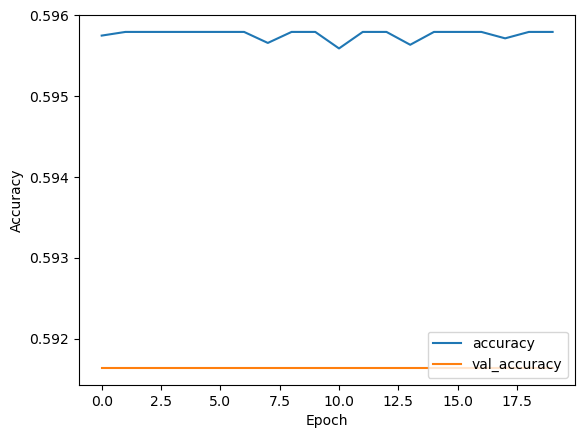

In [17]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

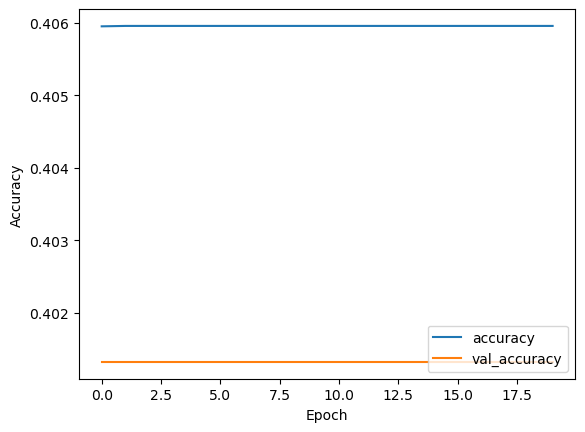

In [14]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

## Test

In [39]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)

228813984/228813984 [==============================] - 18s 0us/step


NameError: name 'pathlib' is not defined

In [40]:
data_dir = Path(archive).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [41]:
data_dir/'*/*'

PosixPath('/home/ivan/.keras/datasets/flower_photos/*/*')

In [42]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [43]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/ivan/.keras/datasets/flower_photos/dandelion/5642429835_a0cbf1bab7_n.jpg'
b'/home/ivan/.keras/datasets/flower_photos/roses/5602220566_5cdde8fa6c_n.jpg'
b'/home/ivan/.keras/datasets/flower_photos/dandelion/17322195031_c2680809dc_m.jpg'
b'/home/ivan/.keras/datasets/flower_photos/tulips/13926327692_a07357ff0d.jpg'
b'/home/ivan/.keras/datasets/flower_photos/daisy/5693459303_e61d9a9533.jpg'


In [44]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [45]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [46]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [ ]:
def get_label(file_path):
  print(file_path)
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])